### **Kaggle Name : Saisriram_Kasiviswanathan**



### Identify different types of cell nuclei in a colon cancer sample

### Import necessary packages 

In [1]:
import os
import torch
import glob
import torch.nn as nn
import tensorflow as tf
import numpy as np
import cv2
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam , SGD
from torch.autograd import Variable
import torchvision
import pathlib
from skimage.io import imread
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# for creating validation set
from sklearn.model_selection import train_test_split
from skimage.transform import resize
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout


### Read the csv file for training and test/prediction dataset

In [2]:
train = pd.read_csv('/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv')
test = pd.read_csv('/kaggle/input/deep-learning-for-msc-coursework-2021/example.csv')
sample_submission = pd.read_csv('/kaggle/input/deep-learning-for-msc-coursework-2021/example.csv')
train.head()

,Id,Type
0,1,Connective
1,2,Connective
2,3,Connective
3,4,Connective
4,5,Connective


### Load the training images and resize it

In [3]:
# loading training images
train_img = []
for img_name in tqdm(train['Id']):
    # Image path
    image_path = '/kaggle/input/deep-learning-for-msc-coursework-2021/train/train/' + str(img_name) + '.png'
     # reading image
    img = imread(image_path)
    # normalizing pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_yy = train['Type'].values
train_x.shape



100%|██████████| 2190/2190 [01:00<00:00, 36.20it/s]


(2190, 224, 224, 3)

### Label the Types with number since we can use numbers only

In [4]:
#labels = ['Cancer' , 'Connective', 'Immune','Normal']

a = {'Cancer' : 0 , 'Connective': 1 , 'Immune': 2 ,'Normal':3 }

arr = []
for i in train_yy:
   arr.append(a[i]) 
train_y = np.asarray(arr)


### Split the training set into training and validation set 

In [5]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.05)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((2080, 224, 224, 3), (2080,)), ((110, 224, 224, 3), (110,)))

### Reshape and convert it into tensor format for both train and validate

In [6]:
train_x = train_x.reshape(2080, 3, 224, 224)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([2080, 3, 224, 224]), torch.Size([2080]))

In [7]:
val_x = val_x.reshape(110, 3,224,224)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([110, 3, 224, 224]), torch.Size([110]))

### Create CNN 

In [8]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            AvgPool2d(3, stride=2)
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32,16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(8, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        

        

        self.linear_layers = Sequential(
            Linear( 196,4)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    

### Define model and optimizer

In [9]:

model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available

    
print(model)


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_run

In [10]:


def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_train = output_train
    output_val = model(x_val)
    output_val = output_val

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    loss_val = criterion(output_val, y_val.long())
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+3, '\t', 'loss :', loss_val)

In [11]:


n_epochs = 15
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  3 	 loss : tensor(1.4061, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.0614, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(0.9810, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(0.9518, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(0.9324, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(0.8968, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(0.8960, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(0.8757, grad_fn=<NllLossBackward>)


##### 

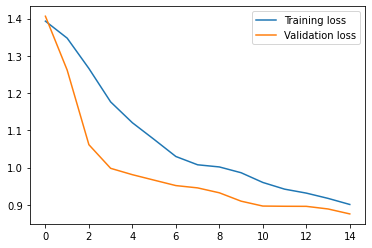

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

### Check training set accuracy

In [13]:
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.6461538461538462

### Check validation set accuracy

In [14]:
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.6818181818181818

### Load testing images

In [15]:
# loading testing images
test_img = []
for img_name in tqdm(test['Id']):
    # defining the image path
    image_path = '/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/' + str(img_name) + '.png'
   # reading the image
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)



100%|██████████| 400/400 [00:10<00:00, 39.84it/s]


(400, 224, 224, 3)

In [16]:
test_x = test_x.reshape(400, 3, 224, 224)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([400, 3, 224, 224])

### Make predictions

In [19]:
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
b = {0:'Cancer', 1:'Connective' , 2:'Immune' ,3:'Normal'}
arrt = []
for i in predictions:
    arrt.append(b[i])
abc = np.asarray(arrt)


### Write predictions in csv file and save it

In [21]:
sample_submission['Type'] = abc

sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()


,Id,Type
0,10001,Cancer
1,10002,Connective
2,10003,Immune
3,10004,Immune
4,10005,Connective
